# Projet ADEME : Recherche opérationnelle

### Importation des librairies

In [2]:
# Importer les bibliothèques nécessaires
import pulp
import random
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque
import pandas as pd
import time
import copy

### Fonctions générales

In [3]:
def generate_graph(n, restricted_edge=0.1, distance_range=(1, 100), time_range=(1, 60)):
    # Crée un graphe complet avec n sommets
    G = nx.complete_graph(n)

    # Parcourt toutes les arêtes du graphe
    for u, v in G.edges():
        # Pour chaque arête, on attribue une distance et un temps
        # Avec une probabilité 'restricted_edge', on met une valeur élevée (999) pour simuler une contrainte
        G[u][v]['distance'] = 999 if random.random() < restricted_edge else random.randint(*distance_range)
        G[u][v]['time'] = 999 if random.random() < restricted_edge else random.randint(*time_range)

    return G

def draw_graph(G, routes=None, depots=[0], title="Graphe complet généré aléatoirement"):
    # Calcule les positions des nœuds pour affichage (mise en page stable grâce à seed=42)
    pos = nx.spring_layout(G, seed=42)

    # Prépare les étiquettes des arêtes avec distance et temps
    edge_labels = {(u, v): f"D:{G.edges[u, v]['distance']}, T:{G.edges[u, v]['time']}" for u, v in G.edges}

    plt.figure(figsize=(8, 5))
    plt.title(title)

    # Affiche les nœuds : verts pour les dépôts, bleus sinon
    nx.draw_networkx_nodes(G, pos, node_color=['lightgreen' if n in depots else 'lightblue' for n in G.nodes], node_size=250)

    # Affiche les étiquettes des nœuds (identifiants)
    nx.draw_networkx_labels(G, pos, font_size=7)

    # Affiche les arêtes en gris clair par défaut
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Si des routes sont fournies, on les dessine en couleurs plus visibles
    if routes:
        line_color = ["red", "blue", "green", "orange", "purple"]
        for k, edges in enumerate(routes):
            nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=line_color[k % len(line_color)])

    # Affiche les étiquettes des arêtes (distance et temps)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

    plt.show()

def print_solution_summary(G, routes, depot=0):
    # Calcule les coûts globaux (somme des distances et des temps)
    total_distance = sum(G.edges[u, v]['distance'] for edges in routes for u, v in edges)
    total_time = max(sum(G.edges[u, v]['time'] for u, v in edges) for edges in routes)

    # Affiche le résumé global
    print("\n\033[1mRÉSUMÉ GLOBAL\033[0m")
    print(f"Distance totale : {total_distance}")
    print(f"Temps max       : {total_time}")

    # En-tête du tableau
    header = f"\n\033[1m{'Camion':<8}{'Distance':>12}{'Temps':>10}   Tournée\033[0m"
    print(header)
    print("-" * (len(header) - 11))

    # Affiche le détail de chaque tournée (par camion)
    for k, edges in enumerate(routes):
        # Calcule la distance et le temps pour chaque camion
        dist = sum(G.edges[u, v]['distance'] for u, v in edges)
        t = sum(G.edges[u, v]['time'] for u, v in edges)

        # --- tentative de reconstruction du chemin dans l'ordre ---
        path = [depot]
        remaining = edges.copy()
        while remaining:
            for idx, (i, j) in enumerate(remaining):
                if i == path[-1]:
                    path.append(j)
                    remaining.pop(idx)
                    break
                elif j == path[-1]:
                    path.append(i)
                    remaining.pop(idx)
                    break
            else:
                # Si on n'arrive pas à déterminer l'ordre du chemin, on ajoute tout ce qui reste à la suite
                path.extend([edge for pair in remaining for edge in pair])
                break

        # Affiche le chemin de la tournée sous forme lisible
        path_str = " → ".join(map(str, path))
        print(f"{k:<8}{dist:>12}{t:>10}   {path_str}")

## Formulation formelle du problème
Le **problème à résoudre** est une version plus complexe du célèbre **problème du voyageur de commerce (TSP)**.
###  Problème du voyageur de commerce (TSP)

Dans le **TSP**, un vendeur doit visiter un certain nombre de villes **une seule fois chacune**, puis **revenir à son point de départ**, en minimisant la **distance totale parcourue**.


###  Problème de tournées de véhicules (VRP)

Le **VRP** (*Vehicle Routing Problem*) est une **généralisation** du TSP.  
Cette fois, il ne s'agit pas d'un seul vendeur, mais de **plusieurs véhicules** qui doivent :

- partir d’un **dépôt central**,
- visiter un ensemble de **clients** pour effectuer des livraisons ou des ramassages,
- puis **revenir au dépôt**.

L’objectif est d’organiser les **tournées de tous les véhicules** pour :

- **desservir tous les clients**,  
- **minimiser les coûts** (distance, temps, coûts...).

## Données du problème
### Représentation du graphe

Le système est modélisé par un **graphe orienté et pondéré** : $ G = (V, E) $

avec :
- $ V = \{v_0, v_1, \dots, v_n\} $   Ensemble des **sommets**, représentant les villes ou les points à visiter.

- $ E \subseteq V \times V $  Ensemble des **arêtes**, représentant les routes entre les villes.

- Chaque arête $ (v_i, v_j) \in E $ est associée à trois **attributs** : la **distance** $ d_{ij} \in \mathbb{R}^{+} $ et le **temps de trajet** $ t_{ij} \in \mathbb{R}^{+} $.


- Un dépôt $ v_0 $ (point de départ et d’arrivée des tournées)

- Un ensemble de $ k $ véhicules, chacun ayant une tournée qui commence et se termine à $ v_0 $

### Objectif

Trouver un ensemble de $ k $ tournées (une par véhicule) telles que :

- Chaque client est visité une seule fois par un seul véhicule
- Le coût total des tournées est **minimisé** (ex. : distance et temps)
- Utilisation de moins de camion possible


### Contraintes

Nous avons choisi d’intégrer deux contraintes supplémentaires au problème de base :

1. **Utilisation de plusieurs véhicules** : chaque véhicule part du dépôt, visite des clients, puis revient au dépôt.
2. **Coût ou restriction de passage sur certaines arêtes** : certaines routes peuvent avoir un coût plus élevé (par exemple, travaux ou routes bloquées)

## Réduction polynomiale VRP vers TSP:
Le but de cette partie est de montrer que le VRP peut être réduit en temps polynomiale.
- Le TSP consiste à trouver une tournée unique qui passe par tous les sommets une seule fois. 
- Le VRP consiste à trouver k tournées, chacune partant et revenant au dépôt $ v_0 $ , desservant tous les clients

## Représentation graphique du VRP

Nous avons commencé à modéliser notre problème VRP. Pour cela, on a utiliser un code python afin de pouvoir afficher nos graphes sans le respect des contraintes qui sera fait durant le projet

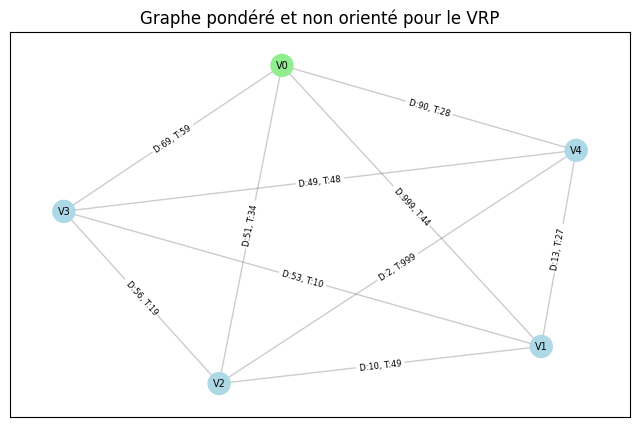

In [4]:
# Définition du nombre de sommets du graphe
N = 5

# Génère un graphe complet avec pondérations aléatoires sur les distances et temps
G = generate_graph(N)

# Renomme les sommets pour qu'ils aient des noms plus lisibles (V0, V1, ..., Vn)
G = nx.relabel_nodes(G, lambda x: f"V{x}")

# Dessine le graphe avec les poids affichés sur chaque arête
# Le sommet 'V0' est défini comme dépôt
draw_graph(G, depots="V0", title="Graphe pondéré et non orienté pour le VRP")

# Affiche le graphe
plt.show()

### Transformation du VRP en TSP

Pour transformer le VRP en TSP, **on crée 𝑘 copies du dépôt dans le graphe**. Ces copies représentent **les 𝑘 tournées distinctes du VRP**. En attribuant des coûts très élevés entre ces copies, on empêche le TSP de relier plusieurs dépôts dans une même boucle. Chaque copie devient ainsi le départ et l’arrivée d’une tournée spécifique, simulant l’utilisation de 𝑘 véhicules dans le TSP.
Plusieurs contraintes sont respectés pour les poids des aretes
- Les distances entre les clients sont conservées
- Les distances entre les copies du dépôt sont fixées à **une grande valeur 𝑀** pour décourager le passage direct entre ces copies
-Les distances entre chaque copie du dépôt $v_0^{(i)}$ et les clients sont égales à celles du dépôt original $v_0$ dans l’instance VRP.


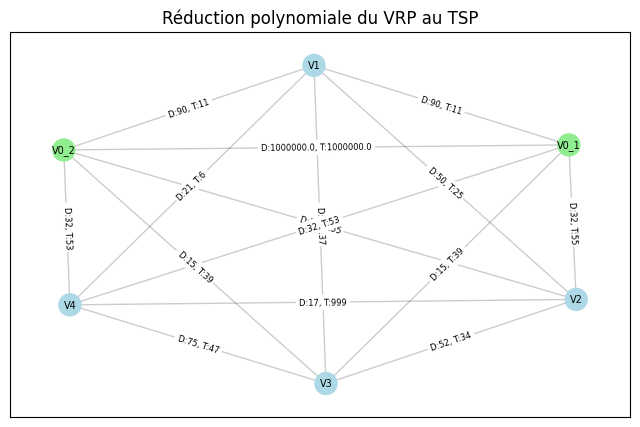

In [5]:
# Nombre de sommets (clients + dépôt)
N = 5
# Nombre de camions
K = 2

# 1. Génère un graphe complet pondéré (distances et temps aléatoires)
G = generate_graph(N)

# Renomme les sommets : V0, V1, ..., VN
G = nx.relabel_nodes(G, lambda x: f"V{x}")

# 2. Duplique le dépôt (V0) en K copies : V0_1, V0_2, ..., V0_K
clients = [n for n in G if n != "V0"]  # On récupère tous les clients (nœuds sauf le dépôt)
for k in range(1, K + 1):
    d = f"V0_{k}"  # Nouveau nom du dépôt pour le k-ième camion
    # On ajoute des arêtes entre le dépôt dupliqué et les clients,
    # en copiant les poids des arêtes initiales entre V0 et chaque client
    G.add_edges_from((d, c, G["V0"][c]) for c in clients)

# 3. Ajoute des arêtes entre dépôts dupliqués avec un coût très élevé
# Cela interdit au TSP de passer directement d’un dépôt à un autre
depots = [f"V0_{k}" for k in range(1, K + 1)]
for i in range(1, K + 1):
    for j in range(i + 1, K + 1):
        G.add_edge(f"V0_{i}", f"V0_{j}", distance=1e6, time=1e6)

# 4. Supprime l’ancien dépôt original ("V0") du graphe
G.remove_node("V0")

# 5. Dessine le graphe modifié avec les dépôts dupliqués mis en évidence
draw_graph(G, depots=depots, title="Réduction polynomiale du VRP au TSP")

###  Conclusion sur la complexité du VRP

Le **Vehicle Routing Problem (VRP)** est une **généralisation** du **problème du voyageur de commerce (TSP)**.

Nous avons montré qu’une instance de VRP peut être transformée en une instance **équivalente de TSP en temps polynomial**, notamment en **dupliquant le dépôt** et en **modifiant les coûts** du graphe.

Or, le **TSP est un problème NP-complet**, ce qui signifie qu’il **n’existe pas d’algorithme polynomial connu** permettant de le résoudre efficacement dans tous les cas.

Cette réduction polynomiale montre donc que le VRP est lui aussi **NP-Difficile**, car **il est au moins aussi complexe que le TSP**.


### Génération des instances aléatoires

In [6]:
# Génère une graine aléatoire entre 0 et 100000
seed = random.randint(0, 100000)

# Initialise le générateur de nombres aléatoires avec cette graine
# Cela permet de reproduire exactement les mêmes résultats si on relance le programme avec la même seed
random.seed(seed)

# Affiche la seed utilisée pour pouvoir la réutiliser si besoin
print(f"Seed : {seed}")

Seed : 93652


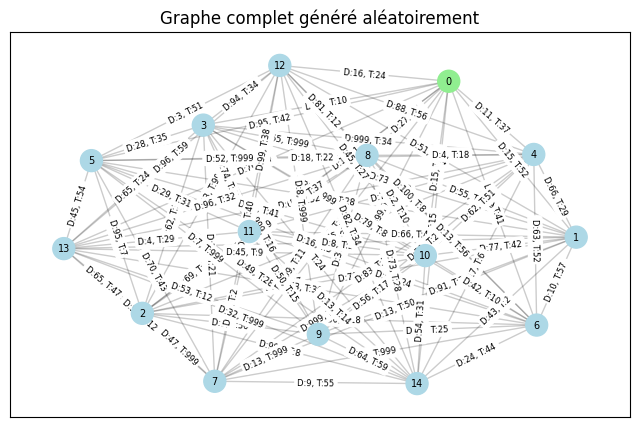

In [7]:
# Nombre de sommets (villes ou points à visiter)
N = 15

# Génération d'un graphe complet avec 15 sommets
# Chaque arête reçoit une distance et un temps aléatoires
G = generate_graph(N)

# Affichage du graphe généré avec les distances et temps sur les arêtes
draw_graph(G)

# Modélisation linéaire du problème de tournées de véhicules pour minimiser la distance (VRP)

Ce modèle linéaire permet de résoudre un problème de tournées de véhicules, où plusieurs camions partent d’un dépôt, visitent des clients, puis reviennent au dépôt.  
L’objectif est de **minimiser la distance totale parcourue** tout en respectant certaines contraintes.


##  Données du problème

Le système est modélisé par un **graphe orienté pondéré** $G = (V, E)$ :

- $V = \{v_0, v_1, ..., v_n\}$ : ensemble des sommets, représentant les clients à visiter.  
- $v_0$ désigne le **dépôt** (point de départ et d’arrivée).
- $E \subseteq V \times V$ : ensemble des arêtes dirigées (routes).
- Chaque arête $(i, j) \in E$ est associée à une **distance** $d_{ij} \in \mathbb{R}^+$.
- $k$ : nombre de véhicules disponibles.


##  Variables de décision

- $x_{ij} \in \{0, 1\}$ : 1 si l’arête $(i, j)$ est empruntée par un véhicule, 0 sinon.

- $u_i \in \mathbb{Z}$ : variable auxiliaire pour éliminer les sous-tours (formulation MTZ), définie pour tous les $i \in \{1, ..., n\}$.



##  Fonction objectif

Minimiser la **distance totale parcourue** :

$$
\min \sum_{(i,j) \in E} d_{ij} \cdot x_{ij}
$$


##  Contraintes

### 1. Visite unique de chaque client

Chaque client doit être visité **exactement une fois** :

$$
\sum_{i \in V,\, i \ne j} x_{ij} = 1 \quad \forall j \in V 
$$

$$
\sum_{j \in V,\, j \ne i} x_{ij} = 1 \quad \forall i \in V 
$$


### 2. Utilisation du dépôt

Le dépôt $v_0$ est utilisé par exactement $k$ véhicules :

$$
\sum_{j \in V } x_{0j} = k
$$

$$
\sum_{i \in V} x_{i0} = k
$$



### 3. Élimination des sous-tours (MTZ)

Pour éviter la création de cycles ne passant pas par le dépôt :

$
1 \le u_i \le n \quad \forall i \in V 
$
$
u_i - u_j + n \cdot x_{ij} \le n - 1 \quad \forall i \ne j,\ i,j \in V
$

##  Interprétation

Ce modèle permet de :

- Planifier les tournées de $k$ véhicules partant et revenant au dépôt $v_0$
- Assurer la visite unique de chaque client
- Éviter les cycles internes sans passer par le dépôt
- **Minimiser la distance totale** pour un impact économique et écologique réduit

In [8]:
def solve_distance_vrp(G, K, depot=0):
    customers = [v for v in G.nodes if v != depot]      # Sommets à visiter
    m = len(customers)                                  # Nombre de clients
    L = m // K                                          # Nombre minimum de clients par camion
    U = L if m % K == 0 else L + 1                      # Nombre maximum de clients par camion

    arcs = [(i, j) for i in G.nodes for j in G.nodes if i != j]

    # --- Définir le problème --- #
    prob = pulp.LpProblem("Distance_VRP", pulp.LpMinimize)

    # --- Variables de décision --- #
    # x[i,j,k] = 1 si le camion k prend l'arc (i,j), 0 sinon
    # u[i,k] = Nombre de clients visités par le camion k avant le client i
    x = pulp.LpVariable.dicts("x", ((i, j, k) for (i, j) in arcs for k in range(K)), lowBound=0, upBound=1, cat="Binary")
    u = pulp.LpVariable.dicts("u", ((i, k) for i in customers for k in range(K)), lowBound=1, upBound=m, cat="Integer")

    # --- Fonction objectif : minimiser la distance totale parcourue --- #
    prob += pulp.lpSum(G.edges[i, j]["distance"] * x[(i, j, k)] for (i, j) in arcs for k in range(K))

    # --- Contraintes --- #
    # Chaque client exactement une fois
    for i in customers:
        prob += pulp.lpSum(x[(i, j, k)] for j in G.nodes if j != i for k in range(K)) == 1

    # Un départ & un retour dépôt par camion
    for k in range(K):
        prob += pulp.lpSum(x[(0, j, k)] for j in customers) == 1
        prob += pulp.lpSum(x[(i, 0, k)] for i in customers) == 1

    # Conservation du flux
    for k in range(K):
        for v in customers:
            prob += (pulp.lpSum(x[(i, v, k)] for i in G.nodes if i != v) - pulp.lpSum(x[(v, j, k)] for j in G.nodes if j != v)) == 0

    # MTZ : élimination des sous-tours
    for k in range(K):
        for i, j in itertools.permutations(customers, 2):
            prob += u[(i, k)] - u[(j, k)] + m * x[(i, j, k)] <= m - 1

    # Équilibrage (même nombre de clients ±1 par camion)
    # L = m // K, U = L + 1 si m % K != 0
    # L <= nombre de clients par camion <= U
    for k in range(K):
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) >= L
        prob += pulp.lpSum(x[(i, j, k)] for i in customers for j in G.nodes if j != i) <= U

    # Résolution
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    # Récupération des arêtes sélectionnées pour chaque camion
    routes = [[] for _ in range(K)]
    for k in range(K):
        for i, j in arcs:
            if pulp.value(x[(i, j, k)]) > 0.5:
                routes[k].append((i, j))

    return routes, pulp.value(prob.objective)


RÉSUMÉ GLOBAL
Distance totale : 152
Temps max       : 2198

Camion      Distance     Temps   Tournée
--------------------------------------
0                101      2198   0 → 1 → 6 → 7 → 3 → 14 → 13 → 11 → 0
1                 51      1226   0 → 4 → 8 → 10 → 2 → 9 → 5 → 12 → 0


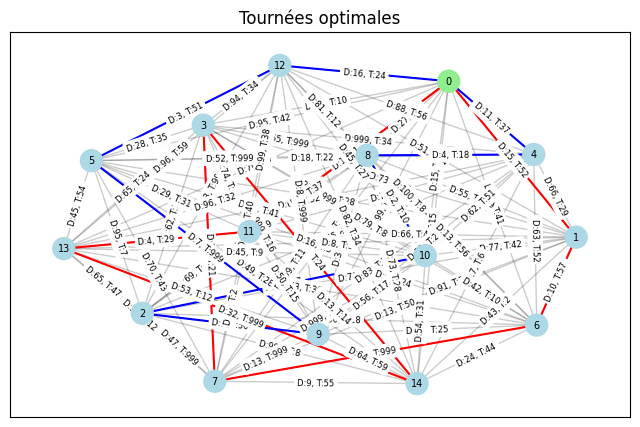

In [9]:
# Cette fonction retourne les routes optimisées et la distance totale minimale.
routes, total_distance = solve_distance_vrp(G, 2)

# Pour chaque tournée, elle affiche les nœuds visités et la distance parcourue.
print_solution_summary(G, routes)

# Affiche le graphe avec les tournées optimales visualisées
draw_graph(G, routes, title="Tournées optimales")

## Méta heuristique
Nous avons fait le choix d'utiliser deux méta heuristiques pour résoudre notre problème de tournées de véhicules. Ces deux algorithmes sont les suivants :
- **la colonie de fourmis** : qui s'inspire du comportement des fourmis pour trouver le chemin le plus court entre le dépôt et les clients.
- **la recherche tabou** : qui utilise une mémoire pour éviter de revisiter les solutions déjà explorées, permettant ainsi d'explorer efficacement l'espace de recherche.

### Colonie de fourmis

Pourquoi avoir choisi la méthaheuristique colonie de fourmis ?

- Elles ne cherchent pas toutes les solutions possibles.  
- Elles explorent intelligemment l’espace des solutions pour trouver de bonnes solutions, parfois très proches de l’optimal.  
- Même si elles ne garantissent pas d'avoir la meilleure solution, elles donnent des résultats très corrects en peu de temps.

Cette méthode s'inspire du comportement des fourmis. Elles sont guidées par des phéromones tout en gardant une part d'exploration. De plus, la méthode est facile à adapter à nos contraintes et limite le risque de rester bloqué dans le problème. Elle fonctionne naturellement sur le système de graphes comme le problème de VRP.


RÉSUMÉ GLOBAL
Distance totale : 152
Temps max       : 2198

Camion      Distance     Temps   Tournée
--------------------------------------
0                101      2198   0 → 11 → 13 → 14 → 3 → 7 → 6 → 1 → 0
1                 51      1226   0 → 4 → 8 → 10 → 2 → 9 → 5 → 12 → 0


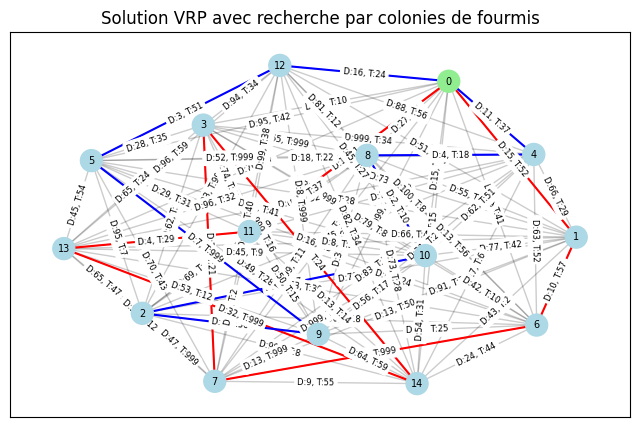

In [17]:
def ant_colony_vrp_fast(graph, depot, nombre_camion=2, num_ants=5, iterations=300,
                        alpha=2, beta=4, evaporation_rate=0.5, pheromone_init=1.5):
    # Initialisation des phéromones sur chaque arête
    pheromones = {edge: pheromone_init for edge in graph.edges}
    
    best_routes = None
    best_cost = float('inf')
    
    # Liste des nœuds sans le dépôt
    nodes = list(graph.nodes)
    nodes.remove(depot)
    
    # Répartition approximative des clients par véhicule
    nodes_per_vehicle = len(nodes) // nombre_camion
    extra_nodes = len(nodes) % nombre_camion
    
    courantes = []              # Coût minimal trouvé à chaque itération
    meilleures_courantes = []   # Meilleur coût global trouvé jusqu'à chaque itération

    for iteration in range(iterations):
        iteration_best_cost = float('inf')  # Meilleur coût de cette itération

        for ant in range(num_ants):  # Pour chaque fourmi
            unvisited = set(graph.nodes)
            unvisited.remove(depot)
            routes = []
            total_cost = 0

            for vehicle in range(nombre_camion):
                current_route = [depot]
                current_node = depot
                visited_this_trip = set()
                
                # Nombre de clients à visiter pour ce véhicule
                nodes_to_visit = nodes_per_vehicle + (1 if vehicle < extra_nodes else 0)

                while unvisited and len(visited_this_trip) < nodes_to_visit:
                    neighbors = [n for n in graph.neighbors(current_node) if n in unvisited]
                    if not neighbors:
                        break

                    probabilities = []
                    for neighbor in neighbors:
                        # Calcul de la probabilité en fonction des phéromones et de la distance
                        edge = (current_node, neighbor) if (current_node, neighbor) in pheromones else (neighbor, current_node)
                        pheromone = pheromones[edge]
                        distance = graph[current_node][neighbor]['distance']
                        probabilities.append((neighbor, (pheromone ** alpha) * ((1 / distance) ** beta)))

                    if not probabilities:
                        break

                    total_prob = sum(prob[1] for prob in probabilities)
                    # Choix du prochain nœud en fonction des probabilités
                    next_node = random.choices(
                        [node for node, _ in probabilities],
                        [prob / total_prob for _, prob in probabilities]
                    )[0]

                    current_route.append(next_node)
                    total_cost += graph[current_node][next_node]['distance']
                    unvisited.remove(next_node)
                    visited_this_trip.add(next_node)
                    current_node = next_node

                # Retour au dépôt à la fin de la tournée
                if current_node != depot:
                    current_route.append(depot)
                    total_cost += graph[current_node][depot]['distance']

                routes.append(current_route)

            # Mise à jour du meilleur coût global et local
            if total_cost < best_cost:
                best_cost = total_cost
                best_routes = routes

            if total_cost < iteration_best_cost:
                iteration_best_cost = total_cost

        courantes.append(iteration_best_cost)
        meilleures_courantes.append(best_cost)

        # Évaporation des phéromones
        for edge in pheromones:
            pheromones[edge] *= (1 - evaporation_rate)

        # Renforcement des arêtes empruntées dans la meilleure solution trouvée
        for route in best_routes:
            for i in range(len(route) - 1):
                edge = (route[i], route[i + 1]) if (route[i], route[i + 1]) in pheromones else (route[i + 1], route[i])
                pheromones[edge] += 1 / best_cost

    # Conversion des routes en listes d'arêtes pour affichage
    formatted_routes = []
    for route in best_routes:
        edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        formatted_routes.append(edges)

    return formatted_routes, best_cost, courantes, meilleures_courantes


# Appel de l'algorithme avec les paramètres définis
best_solution, best_cost, courantes, meilleures_courantes = ant_colony_vrp_fast(
    G, depot=0, nombre_camion=2, num_ants=10, iterations=300,
    alpha=1, beta=2, evaporation_rate=0.5, pheromone_init=1.0
)

# Affichage du résumé de la solution trouvée
print_solution_summary(G, best_solution, depot=0)

# Affichage visuel des tournées sur le graphe
draw_graph(G, best_solution, title="Solution VRP avec recherche par colonies de fourmis")

### Recherche tabou

Pourquoi avoir choisi la méthaheuristique recherche tabou ?

- Elle se souvient des mauvaises solutions récemment visitées grâce à une liste tabou.
- Capacité à améliorer une solution initiale, elle prend souvent une solution de base (intelligente ou aléatoire) et l’améliore progressivement.
- Elle est facile à adapter à nos contraintes et bon compromis qualité / temps.

La recherche tabou est choisie pour le VRP car elle est simple à implémenter, robuste, améliore progressivement les solutions, et surtout, elle évite les blocages dans des solutions locales sous-optimales.


RÉSUMÉ GLOBAL
Distance totale : 201
Temps max       : 3115

Camion      Distance     Temps   Tournée
--------------------------------------
0                117      3115   0 → 12 → 9 → 5 → 6 → 7 → 14 → 3 → 0
1                 84       270   0 → 4 → 8 → 2 → 10 → 11 → 13 → 1 → 0


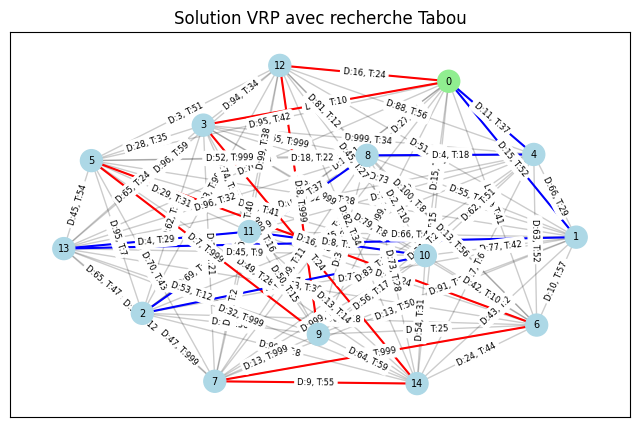

In [11]:
def smart_initial_solution(graph, nombre_camion, depot):
    nodes = list(graph.nodes())
    nodes.remove(depot)
    
    # Trier les clients selon leur distance au dépôt
    nodes.sort(key=lambda node: graph[depot][node]['distance'] if graph.has_edge(depot, node) else graph[node][depot]['distance'])

    # Répartition équilibrée des clients entre les camions
    split = [len(nodes) // nombre_camion] * nombre_camion
    for i in range(len(nodes) % nombre_camion):
        split[i] += 1

    # Construction des routes pour chaque camion
    solution = []
    idx = 0
    for s in split:
        route = [depot] + nodes[idx:idx+s] + [depot]
        idx += s
        solution.append(route)
    return solution


def calculate_cost(graph, solution):
    total_cost = 0
    for route in solution:
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if graph.has_edge(u, v):
                total_cost += graph[u][v]['distance']
            elif graph.has_edge(v, u):
                total_cost += graph[v][u]['distance']
            else:
                total_cost += 9999  # pénalité si arc manquant
    return total_cost


def tabu_search(graph, nombre_camion, depot=0, iterations=500, tabu_tenure=15):
    solution = smart_initial_solution(graph, nombre_camion, depot)  # Solution initiale
    best_solution = [route[:] for route in solution]  # Copie superficielle
    best_cost = calculate_cost(graph, best_solution)
    tabu_list = []

    courantes = []              # Coûts courants à chaque itération
    meilleures_courantes = []   # Meilleurs coûts globaux

    for _ in range(iterations):
        neighborhood = []

        # Génération du voisinage : échange de clients entre camions
        for i in range(nombre_camion):
            for j in range(1, len(solution[i]) - 1):  # Ne pas échanger le dépôt
                for k in range(nombre_camion):
                    if i != k:
                        for l in range(1, len(solution[k]) - 1):
                            neighbor = [route[:] for route in solution]
                            neighbor[i][j], neighbor[k][l] = neighbor[k][l], neighbor[i][j]

                            # Vérification tabou
                            if neighbor not in tabu_list:
                                neighborhood.append((neighbor, calculate_cost(graph, neighbor)))

        if not neighborhood:
            break

        # Sélection du meilleur voisin
        neighborhood.sort(key=lambda x: x[1])
        solution, current_cost = neighborhood[0]

        if current_cost < best_cost:
            best_solution = [route[:] for route in solution]
            best_cost = current_cost

        # Mise à jour de la liste tabou
        tabu_list.append(solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        # Suivi des évolutions
        courantes.append(current_cost)
        meilleures_courantes.append(best_cost)

    # Conversion des routes en listes d’arêtes pour affichage
    routes = []
    for route in best_solution:
        edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        routes.append(edges)
    return routes, best_cost, courantes, meilleures_courantes


# Utilisation de l’algorithme
best_solution, best_cost, courantes, meilleures_courantes = tabu_search(G, nombre_camion=2, depot=0)

# Affichage de la solution trouvée
print_solution_summary(G, best_solution, depot=0)
draw_graph(G, best_solution, title="Solution VRP avec recherche Tabou")

## Comparaison des résultats:

### Test sur plusieurs instances pour évaluer la performance des algorithmes

In [12]:
def run_optimization_algorithm(algorithm, graph, nombre_camion, depot=0, iterations=500, tabu_tenure=15, **kwargs):
    # Création d’un dictionnaire de paramètres communs à tous les algorithmes
    params = {
        "graph": graph,
        "depot": depot,
        "nombre_camion": nombre_camion,
        **kwargs  # Permet d’ajouter d’autres paramètres spécifiques
    }

    # Ajout des paramètres spécifiques si l’algorithme est la recherche tabou
    if algorithm.__name__ == "tabu_search":
        params["iterations"] = iterations
        params["tabu_tenure"] = tabu_tenure

    # Appel de l’algorithme avec tous les paramètres dynamiques
    best_solution, best_cost, courantes, meilleures_courantes = algorithm(**params)

    # Visualisation : évolution du coût au fil des itérations
    plt.xlabel("Nombre d'itérations", fontsize=16)
    plt.ylabel("Coût total", fontsize=16)
    plt.plot(range(len(courantes)), courantes, label="Coût courant", color='blue')
    plt.plot(range(len(meilleures_courantes)), meilleures_courantes, label="Meilleur coût global", color='red')
    plt.legend()
    plt.title(f"Évolution des coûts pour l'algorithme {algorithm.__name__}")
    plt.show()

    return best_solution, best_cost, courantes, meilleures_courantes


Résulat pour la colonie de fourmi

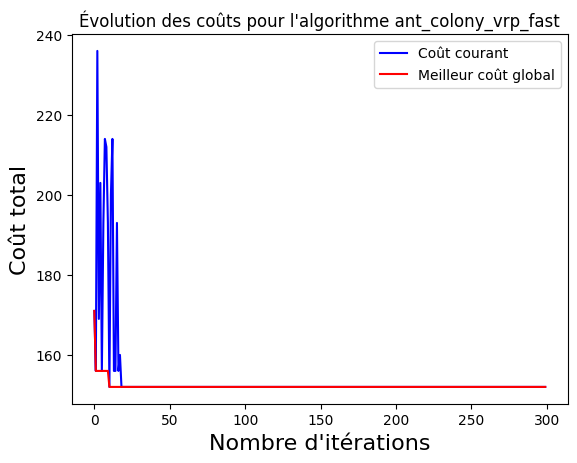


Meilleure solution trouvée :

RÉSUMÉ GLOBAL
Distance totale : 152
Temps max       : 2198

Camion      Distance     Temps   Tournée
--------------------------------------
0                 51      1226   0 → 4 → 8 → 10 → 2 → 9 → 5 → 12 → 0
1                101      2198   0 → 11 → 13 → 14 → 3 → 7 → 6 → 1 → 0


In [13]:
best_routes, best_cost, courantes, meilleures_courantes = run_optimization_algorithm(
    ant_colony_vrp_fast,   # Algorithme choisi : Colonies de fourmis (VRP)
    G,                     # Graphe représentant le réseau (noeuds + distances)
    nombre_camion=2,       # Nombre de camions disponibles
    depot=0,               # Noeud de départ et d’arrivée (dépôt)
    iterations=300,        # Nombre d'itérations (cycles de recherche)
    num_ants=20,           # Nombre de fourmis simulées par itération
    alpha=0.5,             # Poids de l’intensité de la phéromone (exploration)
    beta=2,                # Poids de l’attractivité (distance / exploitation)
    evaporation_rate=0.3   # Taux d’évaporation des phéromones (oublier les mauvaises pistes)
)

# Affichage de la solution trouvée
print("\nMeilleure solution trouvée :")
print_solution_summary(G, best_routes, depot=0)

Résultat pour la recherche tabou :

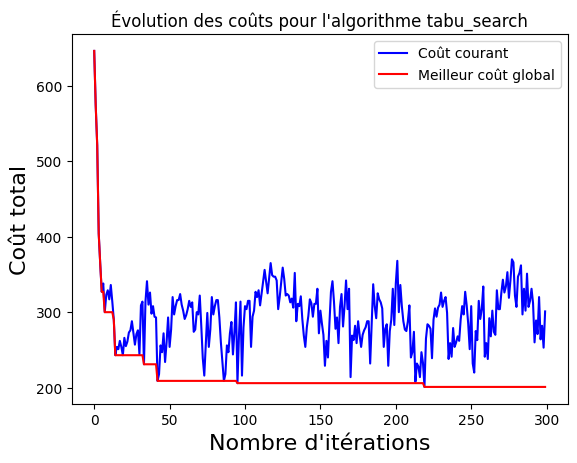


Meilleure solution trouvée :

RÉSUMÉ GLOBAL
Distance totale : 201
Temps max       : 3115

Camion      Distance     Temps   Tournée
--------------------------------------
0                117      3115   0 → 12 → 9 → 5 → 6 → 7 → 14 → 3 → 0
1                 84       270   0 → 4 → 8 → 2 → 10 → 11 → 13 → 1 → 0


In [14]:
iterations = 300  # Nombre d'itérations
tabu_tenure = 20  # Tenure de la liste Tabou
seed = 42  # Pour la reproductibilité
best_solution, best_cost, courantes, meilleures_courantes = run_optimization_algorithm(tabu_search, G, nombre_camion=2, depot=0, iterations=iterations, tabu_tenure=tabu_tenure)

# Affichage de la solution trouvée
print("\nMeilleure solution trouvée :")
print_solution_summary(G, best_solution, depot=0)

Instance 1/10, Seed: 72415
Instance 2/10, Seed: 52094
Instance 3/10, Seed: 21356
Instance 4/10, Seed: 40667
Instance 5/10, Seed: 70246
Instance 6/10, Seed: 40397
Instance 7/10, Seed: 31994
Instance 8/10, Seed: 84634
Instance 9/10, Seed: 90012
Instance 10/10, Seed: 84963

=== Statistiques globales ===
Moyenne et écart type des distances et des temps pour chaque méthode :

         mean_distance  std_distance  mean_time   std_time
method                                                    
Fourmis          311.0     60.382117   0.238569   0.010494
PL               282.1     56.530130  22.216829  23.764481
Tabou            331.8     73.822309   0.264875   0.013772

Moyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :

         mean_diff_distance  std_diff_distance  mean_diff_time  std_diff_time
method                                                                       
Fourmis                28.9          16.037803      -21.978261      23.765645
Tabou       

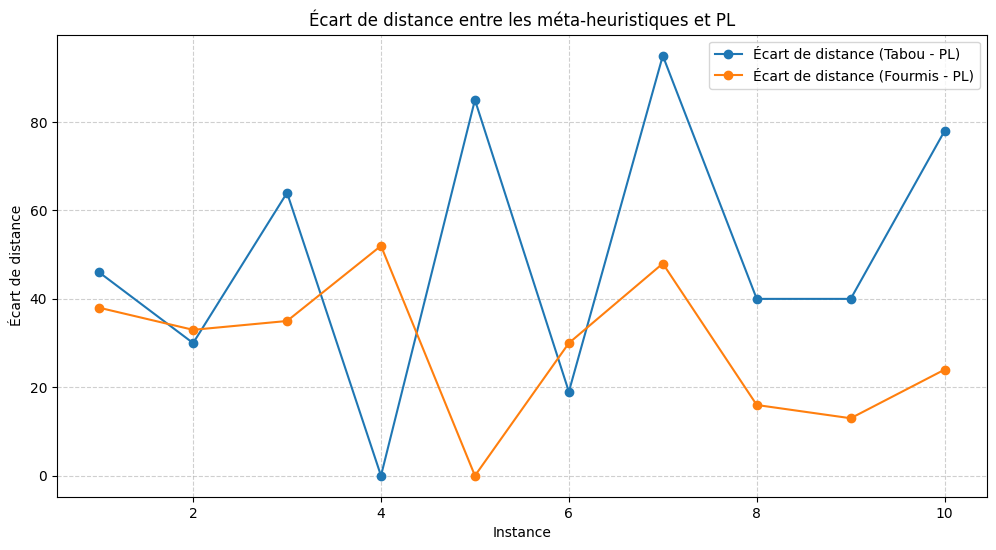

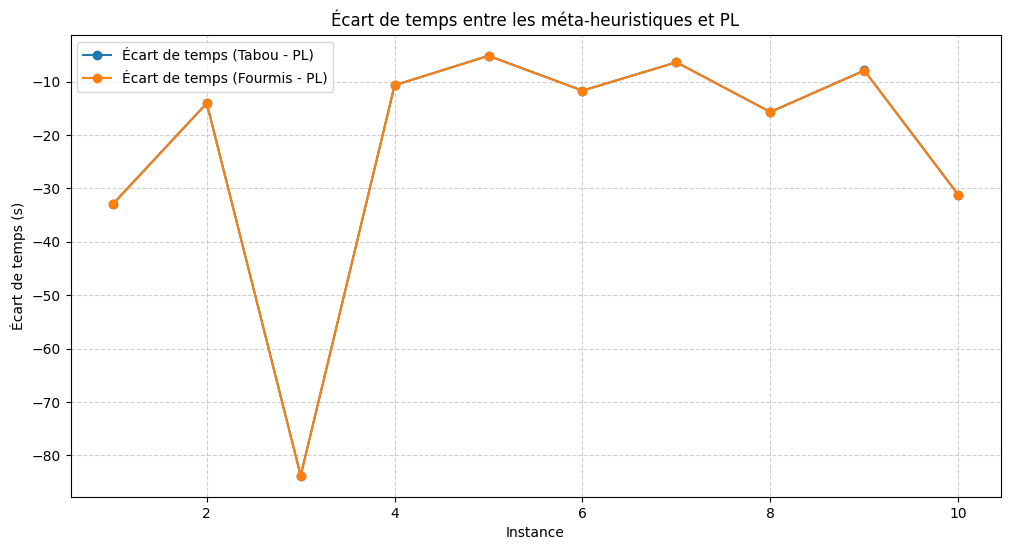

In [ ]:
def run_experiment_with_differences(nombre_camion=2, repetitions=5, n=10):
    """
    Teste les performances des algorithmes PL, Tabou et Fourmis sur des graphes générés aléatoirement,
    et calcule les écarts entre PL et les méta-heuristiques (Tabou, Fourmis).

    Paramètres :
    - nombre_camion : Nombre de camions (par défaut 2).
    - repetitions : Nombre d'instances à générer (par défaut 5).
    - n : Nombre de sommets dans le graphe généré (par défaut 10).
    """
    import time  # Réimportation explicite pour éviter les conflits

    results = {
        'instance': [],
        'method': [],
        'distance': [],
        'time': []
    }

    for rep in range(repetitions):  # Répéter plusieurs fois pour chaque instance
        # Générer une graine unique pour chaque répétition
        seed = random.randint(0, 100000)
        random.seed(seed)
        G_test = generate_graph(n)

        print(f"Instance {rep + 1}/{repetitions}, Seed: {seed}")

        # === Programmation Linéaire (PL) ===
        try:
            start_time = time.time()
            routes_pl, cost_pl = solve_distance_vrp(G_test, nombre_camion, depot=0)
            elapsed_time_pl = time.time() - start_time
        except:
            routes_pl, cost_pl, elapsed_time_pl = None, None, None

        if cost_pl is not None:
            results['instance'].append(rep + 1)
            results['method'].append('PL')
            results['distance'].append(cost_pl)
            results['time'].append(elapsed_time_pl)

        # === Recherche Tabou ===
        start_time = time.time()
        best_tabu_solution, best_tabu_cost, _, _ = tabu_search(
            G_test, nombre_camion, depot=0, iterations=300, tabu_tenure=10
        )
        elapsed_time_tabu = time.time() - start_time

        results['instance'].append(rep + 1)
        results['method'].append('Tabou')
        results['distance'].append(best_tabu_cost)
        results['time'].append(elapsed_time_tabu)

        # === Colonie de Fourmis ===
        start_time = time.time()
        best_aco_routes, best_aco_cost, _, _ = ant_colony_vrp_fast(
            G_test, depot=0, nombre_camion=nombre_camion, num_ants=5, iterations=300
        )
        elapsed_time_aco = time.time() - start_time

        results['instance'].append(rep + 1)
        results['method'].append('Fourmis')
        results['distance'].append(best_aco_cost)
        results['time'].append(elapsed_time_aco)

    # Organisation des résultats dans un DataFrame
    df_results = pd.DataFrame(results)

    # Calcul des écarts entre PL et les méta-heuristiques
    differences = []
    for instance in df_results['instance'].unique():
        pl_row = df_results[(df_results['instance'] == instance) & (df_results['method'] == 'PL')]
        for method in ['Tabou', 'Fourmis']:
            method_row = df_results[(df_results['instance'] == instance) & (df_results['method'] == method)]
            if not pl_row.empty and not method_row.empty:
                diff_distance = method_row['distance'].values[0] - pl_row['distance'].values[0]
                diff_time = method_row['time'].values[0] - pl_row['time'].values[0]
                differences.append({
                    'instance': instance,
                    'method': method,
                    'diff_distance': diff_distance,
                    'diff_time': diff_time
                })

    df_differences = pd.DataFrame(differences)

    # --- Calcul des moyennes et écarts types --- #
    print("\n=== Statistiques globales ===")
    print("Moyenne et écart type des distances et des temps pour chaque méthode :\n")
    stats = df_results.groupby('method').agg(
        mean_distance=('distance', 'mean'),
        std_distance=('distance', 'std'),
        mean_time=('time', 'mean'),
        std_time=('time', 'std')
    )
    print(stats)

    print("\nMoyenne et écart type des écarts (différences) entre PL et les méta-heuristiques :\n")
    diff_stats = df_differences.groupby('method').agg(
        mean_diff_distance=('diff_distance', 'mean'),
        std_diff_distance=('diff_distance', 'std'),
        mean_diff_time=('diff_time', 'mean'),
        std_diff_time=('diff_time', 'std')
    )
    print(diff_stats)

    # --- Graphiques des écarts --- #
    plt.figure(figsize=(12, 6))
    for method in ['Tabou', 'Fourmis']:
        data = df_differences[df_differences['method'] == method]
        plt.plot(data['instance'], data['diff_distance'], marker='o', label=f"Écart de distance ({method} - PL)")
    plt.xlabel('Instance')
    plt.ylabel('Écart de distance')
    plt.title('Écart de distance entre les méta-heuristiques et PL')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    plt.figure(figsize=(12, 6))
    for method in ['Tabou', 'Fourmis']:
        data = df_differences[df_differences['method'] == method]
        plt.plot(data['instance'], data['diff_time'], marker='o', label=f"Écart de temps ({method} - PL)")
    plt.xlabel('Instance')
    plt.ylabel('Écart de temps (s)')
    plt.title('Écart de temps entre les méta-heuristiques et PL')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


run_experiment_with_differences(nombre_camion=2, repetitions=10, n=15)

Instance 1/5, Seed: 54398
Instance 2/5, Seed: 40871
Instance 3/5, Seed: 52584
Instance 4/5, Seed: 45667
Instance 5/5, Seed: 14112

=== Statistiques des distances ===
   instance   method  mean_distance  std_distance
0         1  Fourmis          323.0           NaN
1         1    Tabou          412.0           NaN
2         2  Fourmis          246.0           NaN
3         2    Tabou          244.0           NaN
4         3  Fourmis          324.0           NaN
5         3    Tabou          298.0           NaN
6         4  Fourmis          410.0           NaN
7         4    Tabou          322.0           NaN
8         5  Fourmis          299.0           NaN
9         5    Tabou          345.0           NaN

=== Statistiques des temps ===
   instance   method  mean_time  std_time
0         1  Fourmis   0.113641       NaN
1         1    Tabou   0.114420       NaN
2         2  Fourmis   0.128988       NaN
3         2    Tabou   0.078490       NaN
4         3  Fourmis   0.120711       NaN


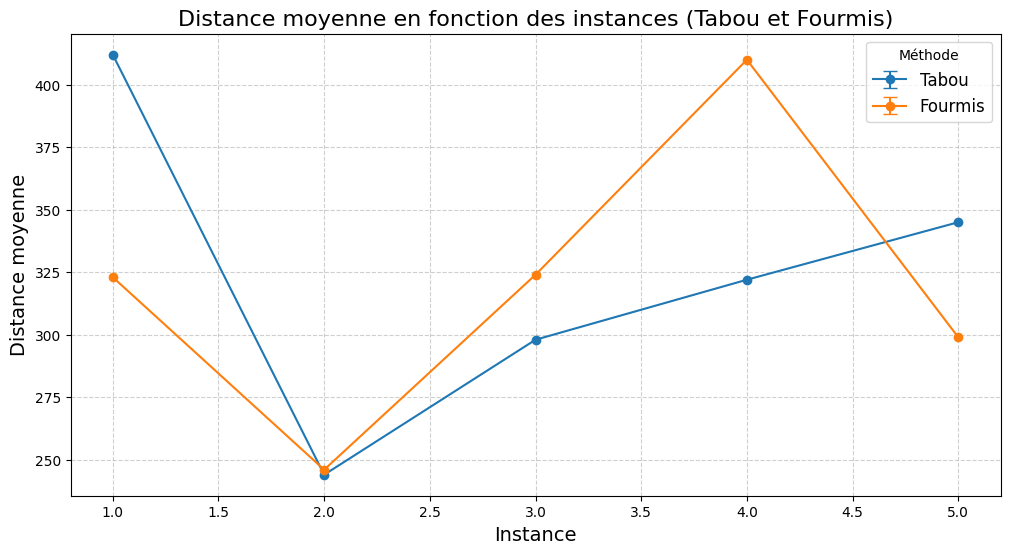

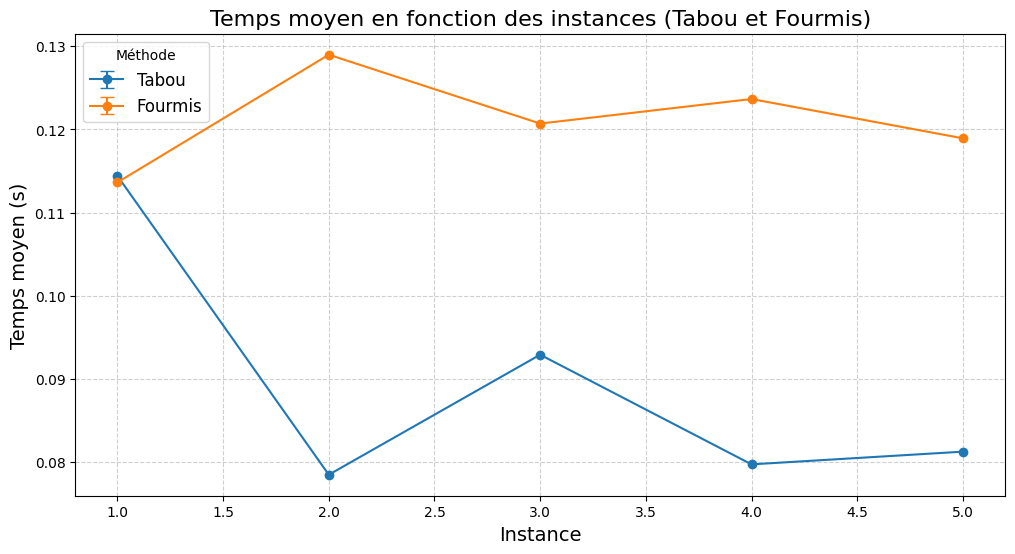

In [ ]:
def run_experiment_with_instances(nombre_camion=2, repetitions=5, graph_size=10):
    """
    Teste les performances des algorithmes Tabou et Fourmis sur plusieurs instances
    d'un graphe de taille fixe, et trace des graphiques des distances moyennes et des temps moyens.

    Paramètres :
    - nombre_camion : Nombre de camions (par défaut 2).
    - repetitions : Nombre d'instances à générer (par défaut 5).
    - graph_size : Taille fixe du graphe (par défaut 10).
    """
    import time  # Réimportation explicite pour éviter les conflits

    results = {
        'instance': [],
        'method': [],
        'distance': [],
        'time': []
    }

    for rep in range(repetitions):  # Répéter pour chaque instance
        # Générer une graine unique pour chaque répétition
        seed = random.randint(0, 100000)
        random.seed(seed)
        G_test = generate_graph(graph_size)

        print(f"Instance {rep + 1}/{repetitions}, Seed: {seed}")

        # === Recherche Tabou ===
        try:
            start_time = time.time()
            best_tabu_solution, best_tabu_cost, _, _ = tabu_search(
                G_test, nombre_camion, depot=0, iterations=300, tabu_tenure=10
            )
            elapsed_time = time.time() - start_time
            results['instance'].append(rep + 1)
            results['method'].append('Tabou')
            results['distance'].append(best_tabu_cost)
            results['time'].append(elapsed_time)
        except:
            pass

        # === Colonie de Fourmis ===
        try:
            start_time = time.time()
            best_aco_routes, best_aco_cost, _, _ = ant_colony_vrp_fast(
                G_test, depot=0, nombre_camion=nombre_camion, num_ants=5, iterations=300
            )
            elapsed_time = time.time() - start_time
            results['instance'].append(rep + 1)
            results['method'].append('Fourmis')
            results['distance'].append(best_aco_cost)
            results['time'].append(elapsed_time)
        except:
            pass

    # Organisation des résultats dans un DataFrame
    df_results = pd.DataFrame(results)

    # Calcul des moyennes et écarts types pour chaque méthode
    stats = df_results.groupby(['instance', 'method']).agg(
        mean_distance=('distance', 'mean'),
        std_distance=('distance', lambda x: abs(x.std())),  # Utilisation de abs() pour garantir un écart type positif
        mean_time=('time', 'mean'),
        std_time=('time', lambda x: abs(x.std()))  # Utilisation de abs() pour garantir un écart type positif
    ).reset_index()

    # Affichage des moyennes et écarts types
    print("\n=== Statistiques des distances ===")
    print(stats[['instance', 'method', 'mean_distance', 'std_distance']])

    print("\n=== Statistiques des temps ===")
    print(stats[['instance', 'method', 'mean_time', 'std_time']])

    # --- Graphique des distances moyennes --- #
    plt.figure(figsize=(12, 6))
    for method in ['Tabou', 'Fourmis']:
        method_data = stats[stats['method'] == method]
        plt.errorbar(
            method_data['instance'], method_data['mean_distance'], yerr=method_data['std_distance'],
            label=method, marker='o', capsize=5
        )
    plt.xlabel('Instance', fontsize=14)
    plt.ylabel('Distance moyenne', fontsize=14)
    plt.title('Distance moyenne en fonction des instances (Tabou et Fourmis)', fontsize=16)
    plt.legend(title='Méthode', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Graphique des temps moyens --- #
    plt.figure(figsize=(12, 6))
    for method in ['Tabou', 'Fourmis']:
        method_data = stats[stats['method'] == method]
        plt.errorbar(
            method_data['instance'], method_data['mean_time'], yerr=method_data['std_time'],
            label=method, marker='o', capsize=5
        )
    plt.xlabel('Instance', fontsize=14)
    plt.ylabel('Temps moyen (s)', fontsize=14)
    plt.title('Temps moyen en fonction des instances (Tabou et Fourmis)', fontsize=16)
    plt.legend(title='Méthode', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# Appel de la fonction avec plusieurs instances
run_experiment_with_instances(nombre_camion=2, repetitions=20, graph_size=15)

Taille du graphe : 5, Instance 1/5, Seed: 15947
Taille du graphe : 5, Instance 2/5, Seed: 62821
Taille du graphe : 5, Instance 3/5, Seed: 260
Taille du graphe : 5, Instance 4/5, Seed: 1231
Taille du graphe : 5, Instance 5/5, Seed: 64252
Taille du graphe : 6, Instance 1/5, Seed: 75451
Taille du graphe : 6, Instance 2/5, Seed: 21763
Taille du graphe : 6, Instance 3/5, Seed: 94385
Taille du graphe : 6, Instance 4/5, Seed: 57834
Taille du graphe : 6, Instance 5/5, Seed: 18820
Taille du graphe : 7, Instance 1/5, Seed: 77077
Taille du graphe : 7, Instance 2/5, Seed: 83508
Taille du graphe : 7, Instance 3/5, Seed: 31827
Taille du graphe : 7, Instance 4/5, Seed: 32426
Taille du graphe : 7, Instance 5/5, Seed: 25824
Taille du graphe : 8, Instance 1/5, Seed: 20523
Taille du graphe : 8, Instance 2/5, Seed: 34311
Taille du graphe : 8, Instance 3/5, Seed: 82122
Taille du graphe : 8, Instance 4/5, Seed: 9046
Taille du graphe : 8, Instance 5/5, Seed: 87894
Taille du graphe : 9, Instance 1/5, Seed: 71

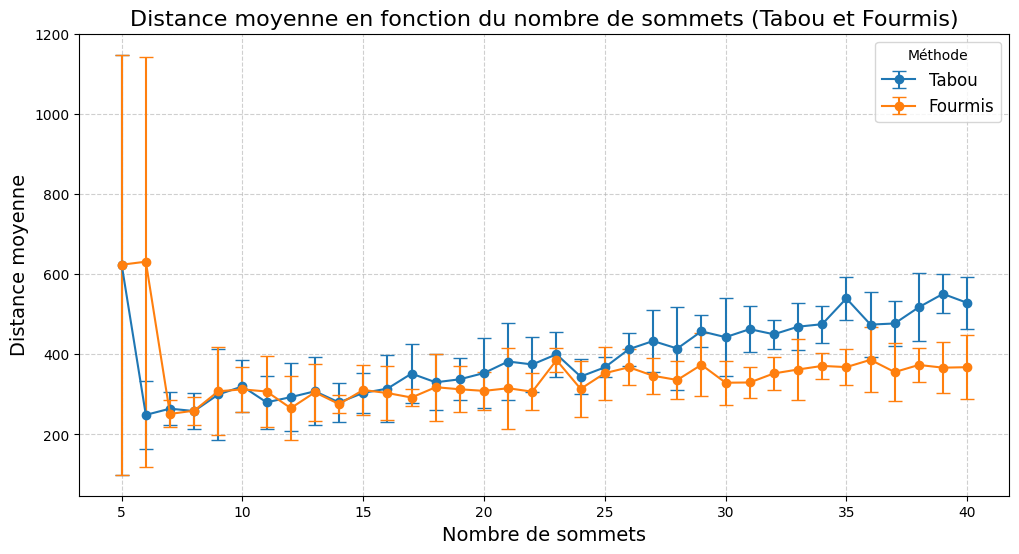

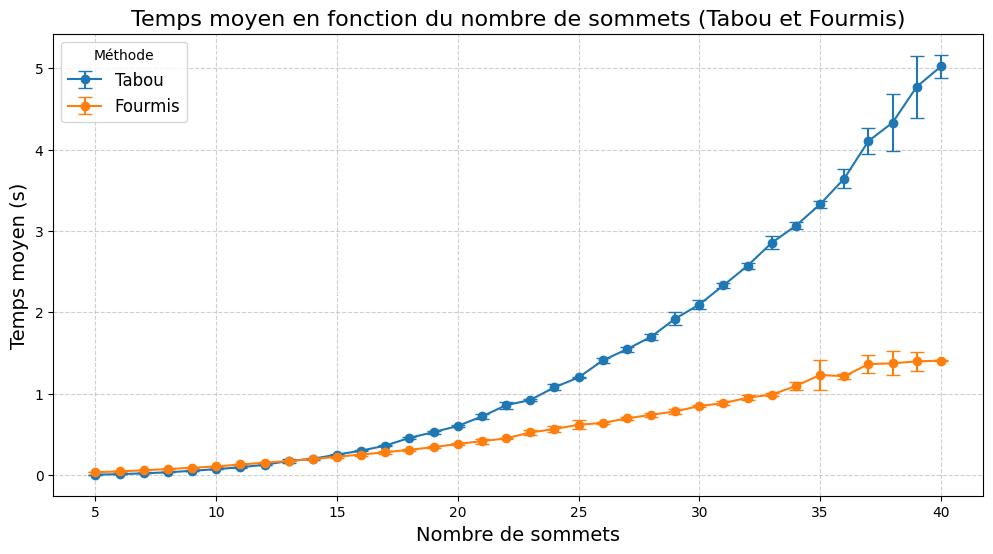

In [22]:
def run_experiment_without_pl(nombre_camion=2, repetitions=5, min_n=5, max_n=15):
    """
    Teste les performances des algorithmes Tabou et Fourmis sur des graphes de tailles variables,
    et trace des graphiques des distances moyennes et des temps moyens en fonction du nombre de sommets.

    Paramètres :
    - nombre_camion : Nombre de camions (par défaut 2).
    - repetitions : Nombre d'instances à générer pour chaque taille de graphe (par défaut 5).
    - min_n : Taille minimale du graphe (par défaut 5).
    - max_n : Taille maximale du graphe (par défaut 15).
    """
    import time  # Réimportation explicite pour éviter les conflits

    results = {
        'graph_size': [],
        'method': [],
        'distance': [],
        'time': []
    }

    for n in range(min_n, max_n + 1):  # Faire varier la taille des graphes
        for rep in range(repetitions):  # Répéter plusieurs fois pour chaque taille
            # Générer une graine unique pour chaque répétition
            seed = random.randint(0, 100000)
            random.seed(seed)
            G_test = generate_graph(n)

            print(f"Taille du graphe : {n}, Instance {rep + 1}/{repetitions}, Seed: {seed}")

            # === Recherche Tabou ===
            try:
                start_time = time.time()
                best_tabu_solution, best_tabu_cost, _, _ = tabu_search(
                    G_test, nombre_camion, depot=0, iterations=300, tabu_tenure=10
                )
                elapsed_time = time.time() - start_time
                results['graph_size'].append(n)
                results['method'].append('Tabou')
                results['distance'].append(best_tabu_cost)
                results['time'].append(elapsed_time)
            except:
                pass

            # === Colonie de Fourmis ===
            try:
                start_time = time.time()
                best_aco_routes, best_aco_cost, _, _ = ant_colony_vrp_fast(
                    G_test, depot=0, nombre_camion=nombre_camion, num_ants=5, iterations=300
                )
                elapsed_time = time.time() - start_time
                results['graph_size'].append(n)
                results['method'].append('Fourmis')
                results['distance'].append(best_aco_cost)
                results['time'].append(elapsed_time)
            except:
                pass

    # Organisation des résultats dans un DataFrame
    df_results = pd.DataFrame(results)

    # Calcul des moyennes et écarts types pour chaque méthode et taille de graphe
    stats = df_results.groupby(['graph_size', 'method']).agg(
        mean_distance=('distance', 'mean'),
        std_distance=('distance', lambda x: abs(x.std())),  # Utilisation de abs() pour garantir un écart type positif
        mean_time=('time', 'mean'),
        std_time=('time', lambda x: abs(x.std()))  # Utilisation de abs() pour garantir un écart type positif
    ).reset_index()

    # Affichage des moyennes et écarts types
    print("\n=== Statistiques des distances ===")
    print(stats[['graph_size', 'method', 'mean_distance', 'std_distance']])

    print("\n=== Statistiques des temps ===")
    print(stats[['graph_size', 'method', 'mean_time', 'std_time']])

    # --- Graphique des distances moyennes --- #
    plt.figure(figsize=(12, 6))
    for method in ['Tabou', 'Fourmis']:
        method_data = stats[stats['method'] == method]
        plt.errorbar(
            method_data['graph_size'], method_data['mean_distance'], yerr=method_data['std_distance'],
            label=method, marker='o', capsize=5
        )
    plt.xlabel('Nombre de sommets', fontsize=14)
    plt.ylabel('Distance moyenne', fontsize=14)
    plt.title('Distance moyenne en fonction du nombre de sommets (Tabou et Fourmis)', fontsize=16)
    plt.legend(title='Méthode', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Graphique des temps moyens --- #
    plt.figure(figsize=(12, 6))
    for method in ['Tabou', 'Fourmis']:
        method_data = stats[stats['method'] == method]
        plt.errorbar(
            method_data['graph_size'], method_data['mean_time'], yerr=method_data['std_time'],
            label=method, marker='o', capsize=5
        )
    plt.xlabel('Nombre de sommets', fontsize=14)
    plt.ylabel('Temps moyen (s)', fontsize=14)
    plt.title('Temps moyen en fonction du nombre de sommets (Tabou et Fourmis)', fontsize=16)
    plt.legend(title='Méthode', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# Appel de la fonction avec plusieurs tailles de graphes
run_experiment_without_pl(nombre_camion=2, repetitions=5, min_n=5, max_n=40)

### Analyse du graphique : Distance moyenne en fonction du nombre de sommets (Tabou et Fourmis)

- **Description générale** :
  Ce graphique montre l'évolution de la distance moyenne parcourue par les algorithmes **Tabou** et **Colonie de Fourmis** en fonction du nombre de sommets dans le graphe.

- **Observations** :
  - Pour les graphes de petite taille (5 à 10 sommets), les distances moyennes varient fortement, ce qui peut être dû à la nature aléatoire des graphes générés.
  - À mesure que le nombre de sommets augmente, les distances moyennes augmentent également, ce qui est attendu car un graphe plus grand implique des trajets plus longs.
  - L'algorithme **Colonie de Fourmis** semble produire des distances légèrement inférieures à celles de **Tabou** pour la plupart des tailles de graphes, ce qui pourrait indiquer une meilleure optimisation dans ce cas.

- **Interprétation** :
  - La **Colonie de Fourmis** semble être plus stable et performante en termes de distance moyenne, bien que cela dépende des paramètres spécifiques des algorithmes.

In [ ]:
def run_experiment_with_pl(nombre_camion=2, repetitions=5, min_n=5, max_n=15):
    """
    Teste les performances des algorithmes PL, Tabou et Fourmis sur des graphes de tailles variables,
    et trace des graphiques des distances moyennes, des temps moyens et des écarts moyens avec PL.

    Paramètres :
    - nombre_camion : Nombre de camions (par défaut 2).
    - repetitions : Nombre d'instances à générer pour chaque taille de graphe (par défaut 5).
    - min_n : Taille minimale du graphe (par défaut 5).
    - max_n : Taille maximale du graphe (par défaut 15).
    """
    import time  # Réimportation explicite pour éviter les conflits

    results = {
        'graph_size': [],
        'method': [],
        'distance': [],
        'time': []
    }

    for n in range(min_n, max_n + 1):  # Faire varier la taille des graphes
        for rep in range(repetitions):  # Répéter plusieurs fois pour chaque taille
            # Générer une graine unique pour chaque répétition
            seed = random.randint(0, 100000)
            random.seed(seed)
            G_test = generate_graph(n)

            print(f"Taille du graphe : {n}, Instance {rep + 1}/{repetitions}, Seed: {seed}")

            # === Programmation Linéaire (PL) ===
            try:
                start_time = time.time()
                routes_pl, cost_pl = solve_distance_vrp(G_test, nombre_camion, depot=0)
                elapsed_time = time.time() - start_time
                results['graph_size'].append(n)
                results['method'].append('PL')
                results['distance'].append(cost_pl)
                results['time'].append(elapsed_time)
            except:
                pass

            # === Recherche Tabou ===
            try:
                start_time = time.time()
                best_tabu_solution, best_tabu_cost, _, _ = tabu_search(
                    G_test, nombre_camion, depot=0, iterations=300, tabu_tenure=10
                )
                elapsed_time = time.time() - start_time
                results['graph_size'].append(n)
                results['method'].append('Tabou')
                results['distance'].append(best_tabu_cost)
                results['time'].append(elapsed_time)
            except:
                pass

            # === Colonie de Fourmis ===
            try:
                start_time = time.time()
                best_aco_routes, best_aco_cost, _, _ = ant_colony_vrp_fast(
                    G_test, depot=0, nombre_camion=nombre_camion, num_ants=5, iterations=300
                )
                elapsed_time = time.time() - start_time
                results['graph_size'].append(n)
                results['method'].append('Fourmis')
                results['distance'].append(best_aco_cost)
                results['time'].append(elapsed_time)
            except:
                pass

    # Organisation des résultats dans un DataFrame
    df_results = pd.DataFrame(results)

    # Calcul des moyennes et écarts types pour chaque méthode et taille de graphe
    stats = df_results.groupby(['graph_size', 'method']).agg(
        mean_distance=('distance', 'mean'),
        std_distance=('distance', lambda x: abs(x.std())),  # Utilisation de abs() pour garantir un écart type positif
        mean_time=('time', 'mean'),
        std_time=('time', lambda x: abs(x.std()))  # Utilisation de abs() pour garantir un écart type positif
    ).reset_index()

    # Calcul des écarts moyens avec PL
    differences = []
    for n in df_results['graph_size'].unique():
        pl_row = stats[(stats['graph_size'] == n) & (stats['method'] == 'PL')]
        for method in ['Tabou', 'Fourmis']:
            method_row = stats[(stats['graph_size'] == n) & (stats['method'] == method)]
            if not pl_row.empty and not method_row.empty:
                diff_distance = method_row['mean_distance'].values[0] - pl_row['mean_distance'].values[0]
                differences.append({
                    'graph_size': n,
                    'method': method,
                    'diff_distance': diff_distance
                })

    df_differences = pd.DataFrame(differences)

    # Affichage des moyennes et écarts types
    print("\n=== Statistiques des distances ===")
    print(stats[['graph_size', 'method', 'mean_distance', 'std_distance']])

    print("\n=== Statistiques des temps ===")
    print(stats[['graph_size', 'method', 'mean_time', 'std_time']])

    print("\n=== Écarts moyens avec PL ===")
    print(df_differences)

    # --- Graphique des distances moyennes --- #
    plt.figure(figsize=(12, 6))
    for method in ['PL', 'Tabou', 'Fourmis']:
        method_data = stats[stats['method'] == method]
        plt.errorbar(
            method_data['graph_size'], method_data['mean_distance'], yerr=method_data['std_distance'],
            label=method, marker='o', capsize=5
        )
    plt.xlabel('Nombre de sommets', fontsize=14)
    plt.ylabel('Distance moyenne', fontsize=14)
    plt.title('Distance moyenne en fonction du nombre de sommets (PL, Tabou et Fourmis)', fontsize=16)
    plt.legend(title='Méthode', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Graphique des écarts moyens avec PL --- #
    plt.figure(figsize=(12, 6))
    for method in ['Tabou', 'Fourmis']:
        method_data = df_differences[df_differences['method'] == method]
        plt.plot(
            method_data['graph_size'], method_data['diff_distance'], marker='o', label=f'Écart avec PL ({method})'
        )
    plt.xlabel('Nombre de sommets', fontsize=14)
    plt.ylabel('Écart moyen de distance avec PL', fontsize=14)
    plt.title('Écart moyen de distance avec PL en fonction du nombre de sommets', fontsize=16)
    plt.legend(title='Méthode', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


# Appel de la fonction avec plusieurs tailles de graphes
run_experiment_with_pl(nombre_camion=2, repetitions=5, min_n=5, max_n=15)

Taille du graphe : 5, Instance 1/5, Seed: 3797
Taille du graphe : 5, Instance 2/5, Seed: 95204
Taille du graphe : 5, Instance 3/5, Seed: 40011
Taille du graphe : 5, Instance 4/5, Seed: 27904
Taille du graphe : 5, Instance 5/5, Seed: 57257
Taille du graphe : 6, Instance 1/5, Seed: 46197
Taille du graphe : 6, Instance 2/5, Seed: 38369
Taille du graphe : 6, Instance 3/5, Seed: 65064
Taille du graphe : 6, Instance 4/5, Seed: 87101
Taille du graphe : 6, Instance 5/5, Seed: 50542
Taille du graphe : 7, Instance 1/5, Seed: 58044
Taille du graphe : 7, Instance 2/5, Seed: 99551
Taille du graphe : 7, Instance 3/5, Seed: 79861
Taille du graphe : 7, Instance 4/5, Seed: 44952
Taille du graphe : 7, Instance 5/5, Seed: 20302
Taille du graphe : 8, Instance 1/5, Seed: 2059
Taille du graphe : 8, Instance 2/5, Seed: 71706
Taille du graphe : 8, Instance 3/5, Seed: 89814
Taille du graphe : 8, Instance 4/5, Seed: 96419
Taille du graphe : 8, Instance 5/5, Seed: 20651
Taille du graphe : 9, Instance 1/5, Seed: 

### Références utiles

- https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce
- https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_tourn%C3%A9es_de_v%C3%A9hicules
- Workshop
- https://networkx.org/documentation/stable/reference/introduction.html
- https://www.guru99.com/fr/travelling-salesman-problem.html#:~:text=Le%20probl%C3%A8me%20du%20voyageur%20de%20commerce%20%28TSP%29%20est,fa%C3%A7on%20exponentielle%20avec%20l%E2%80%99augmentation%20du%20nombre%20de%20villes.
- https://github.com/jwang0306/vehicle-routing-problem?tab=readme-ov-file
- https://www.youtube.com/watch?v=GiDsjIBOVoA&list=TLPQMjcwNDIwMjWGmE-QXy8F6w&index=1&pp=gAQBiAQB